# Quickstart

## Introduction 

`sensemakr` for Python (PySensemakr) implements a suite of sensitivity analysis tools that makes it easier to understand the impact of omitted variables in linear regression models, as discussed in [Cinelli, C. and Hazlett, C. (2020) “Making
Sense of Sensitivity: Extending Omitted Variable Bias.” Journal of the
Royal Statistical Society, Series B (Statistical
Methodology).](https://doi.org/10.1111/rssb.12348) The Python version of the package closely mirrors the R version, which can be found [here](https://github.com/carloscinelli/sensemakr). 

In this quickstart, we demonstrate the basic usage of the package by reproducing  Section 5 of Cinelli and Hazlett (2020), which estimates the effects of exposure to violence on attitudes towards peace, in Darfur. Throughout this manual, we mainly focus on the code. For detailed explanations, please refer to the original paper.

## Violence in Darfur

In 2003 and 2004, the Darfurian government orchestrated a horrific campaign of violence against civilians, killing an estimated two hundred thousand people. In this application, we are interested in answering the following question: did being directly exposed to harm make individuals more "angry," and thus more likely to ask for revenge, or did it make them more "weary," and thus more likely to ask for peace?  

`PySensemakr` comes with the Darfur dataset, which can be loaded with the command `data.load_darfur()`. More details about the data can be found in the documentation, as well as in Hazlett (2019) and Cinelli and Hazlett (2020).

In [1]:
# imports sensemakr
import sensemakr as smkr

# loads darfur data
darfur = smkr.load_darfur()
darfur.head()

,wouldvote,peacefactor,peace_formerenemies,peace_jjindiv,peace_jjtribes,gos_soldier_execute,directlyharmed,age,farmer_dar,herder_dar,pastvoted,hhsize_darfur,village,female
0,0,1.000000,1,1,1,0,0,30,0,0,1,23,Abdel Khair,0
1,0,0.706831,0,1,1,0,0,20,1,0,1,5,Abdi Dar,1
2,1,0.000000,0,0,0,1,0,45,1,0,0,15,Abu Sorog,0
3,1,0.495178,1,0,0,0,1,55,0,0,0,9,Abu Dejaj,0
4,0,0.000000,0,0,0,1,1,25,1,0,1,7,Abu Dejaj,1


A natural approach for such problem is to run the following linear regression model, where we regress `peacefactor` on `directlyharmed`, further adjusting for `village`, `female` as well as other covariates. Here we run this regression using `statsmodel`.

In [2]:
# imports 
import statsmodels.formula.api as smf

# runs regression model
reg_model = smf.ols(formula='peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + '\
                    'pastvoted + hhsize_darfur + female + village', data=darfur)
darfur_model = reg_model.fit()

The above regression results in the following estimate and standard errors for the coefficient of `directlyharmed`:

In [3]:
# imports statsmodels summary_col function
from statsmodels.iolib.summary2 import summary_col

# summary of regression results for directlyharmed
summary_col(darfur_model, regressor_order=["directlyharmed"], drop_omitted=True)

,peacefactor
directlyharmed,0.0973
,(0.0233)
R-squared,0.5115
R-squared Adj.,0.2046


According to this model, those individual who were directly exposed to harm became on average more “pro-peace,” not less.

## Sensitivity Analysis
The causal interpretation of the previous estimate, however, relies on the assumption that `village` and `gender` are sufficient for control of confounding---in other words, it requires the assumption of *no unobserved confounders*. What if is wrong? How strong would these unobserved variables have to be in order to change the original research conclusions? The goal of `sensemakr' is precisely that, i.e, to make it easier to understand the impact that omitted variables would have on a regression result.  

The main function of the package is the function `Sensemakr`. The `Sensemakr` function defines an object of class `Sensemakr,`  performing the most commonly required sensitivity analyses which can then be further explored with the `summary` and `plot` methods of the object. This function is mainly a convenience wrapper for other sensitivity functions defined in the package, which can also be called directly, as we detail later in the documentation. 

In the code chunk below, we apply the function `Sensemakr` to our OLS model from `statsmodel`.

In [4]:
# creates a Sensemakr object
darfur_sense = smkr.Sensemakr(model = darfur_model, 
                              treatment = "directlyharmed", 
                              benchmark_covariates = ["female"], 
                              kd = [1,2,3],
                              ky = [1,2,3],
                              q = 1.0, 
                              alpha = 0.05, 
                              reduce = True)

The main arguments of the call are:

**model**: the OLS model with the outcome regression. In our case, `darfur_model`.


**treatment**: the name of the treatment variable. In our case, "directlyharmed".


**benchmark_covariates**: the names of covariates that will be used to bound the plausible strength of the unobserved confounders. Here, we put "female", which is arguably one of the main determinants of exposure to violence, and also a strong determinant of attitudes towards peace.


**kd** and **ky**: these arguments parameterize how many times stronger the confounder is related to the treatment (kd) and to the outcome (ky) in comparison to the observed benchmark covariates (in this case, female). In our example, setting `kd = [1, 2, 3]` and `ky = [1,2,3]` means we want to investigate the maximum strength of a confounder once, twice, or three times as strong as female (in explaining treatment and outcome variation). If only `kd` is given, `ky` will be set equal to `kd`.


**q**: fraction of the effect estimate that would have to be explained away to be problematic. Setting q = 1, means that a reduction of 100% of the current effect estimate, that is, a true effect of zero, would be deemed problematic. The default is 1.


**alpha**: significance level of interest for statistical inference. The default is 0.05.


**reduce**: should we consider confounders acting towards increasing or reducing the absolute value of the estimate? The default is `reduce = True`, which means we are considering confounders that pull the estimate towards (or through) zero.


Using the default arguments, one can simplify the previous call to:

In [5]:
# creates a Sensemakr object
darfur_sense = smkr.Sensemakr(model = darfur_model, 
                              treatment = "directlyharmed", 
                              benchmark_covariates = ["female"], 
                              kd = [1,2,3])

Once we run `Sensemakr`, we can now explore the sensitivity analysis results.

### Minimal sensitivity reporting

The print method of Sensemakr provides a quick review of the original (unadjusted) estimates along with three summary sensitivity statistics suited for routine reporting: the partial $R^2$ of the treatment with the outcome, the robustness value ($RV$) required to reduce the estimate entirely to zero (i.e. $q=1$), and the RV beyond which the estimate would no longer be statistically distinguishable from zero at the 0.05 level $(q=1, \alpha = 0.05)$

In [6]:
# basic print
darfur_sense.print()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1 and reduce = True 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1 : 0.139
  Robustness Value, q = 1 alpha = 0.05 : 0.076 



The package also provides a function that outputs code for a latex or html table with these results. If used in an interactive environment, such as a Jupyter notebook, the table is also automatically displayed in the notebook.

In [7]:
# html code for minimal reporting table
html_code = darfur_sense.ovb_minimal_reporting(format = "html")

Outcome: peacefactor 
 
 
 Treatment 
 Est. 
 S.E. 
 t-value 
 R 2 Y~D|X 
 RV q = 1 
 RV q = 1, α = 0.05 
 
 
 
 
 directlyharmed 
 0.097 
 0.023 
 4.2 
 2.2% 
 13.9% 
 7.6% 
 
 
 
 Note: df = 783; Bound ( 1x female ): R 2 Y~Z|X,D = 12.5%, R 2 D~Z|X =0.9%

These three sensitivity statistics provide a minimal reporting for sensitivity analysis. More precisely:

The robustness value for bringing the point estimate of directlyharmed exactly to zero $(RV_{q=1})$ is 13.9% . This means that unobserved confounders that explain 13.9% of the residual variance both of the treatment and of the outcome are sufficiently strong to explain away all the observed effect. On the other hand, unobserved confounders that do not explain at least 13.9% of the residual variance both of the treatment and of the outcome are not sufficiently strong to do so.

The robustness value for testing the null hypothesis that the coefficient of directlyharmed is zero $(RV_{q=1, \alpha = 0.05})$ falls to 7.6%. This means that unobserved confounders that explain 7.6% of the residual variance both of the treatment and of the outcome are sufficiently strong to bring the lower bound of the confidence interval to zero (at the chosen significance level of 5%). On the other hand, unobserved confounders that do not explain at least 7.6% of the residual variance both of the treatment and of the outcome are not sufficiently strong to do so.

Finally, the partial $R^2$ of directlyharmed with peacefactor means that, in an extreme scenario, in which we assume that unobserved confounders explain all of the left out variance of the outcome, these unobserved confounders would need to explain at least 2.2% of the residual variance of the treatment to fully explain away the observed effect.

The lower corner of the table, further provides bounds on the strength of an unobserved confounder *as strong as* the observed covariate `female`, resulting in $R^2_{Y\sim Z\mid X, D} = 12.5\%$  and $R^2_{D\sim Z\mid X} = .9\%$ . Since both of those are below the RV of 13.9\%, we conclude confounders as strong as female, in explaining treatment and outcome variations, are not sufficiently strong to explain away the observed estimate.

Moreover, the bound of $R^2_{D\sim Z\mid X} = .9\%$ is below the partial 𝑅2 of the treatment with the outcome, $R^2_{Y\sim D\mid X} = 2.2\%$, this means that even an extreme confounder explaining *all* residual variation of the outcome, and as strongly associated with the treatment as female would not be able to overturn the research conclusions.

The summary method of Sensemakr produces verbose output similar to the text explanations above, so that researchers can directly cite or include such texts in their reports.

In [8]:
# extended summary
darfur_sense.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1 : 0.139
  Robustness Value, q = 1 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187 % of the residual variance of the treatment to fully account for the observed estimated effect.

-- Robustness Valu

### Sensitivity contour plots

 Using the plot method for `Sensemakr`, we can further refine our sensitivity analysis by *visually* exploring the whole range of possible estimates that confounders with different strengths could cause.

Let us begin by examining contour plots for the point estimate.


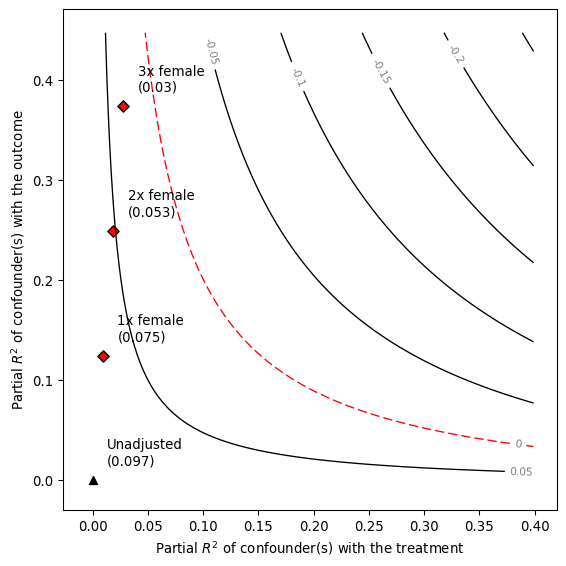

In [9]:
# contour plot for the estimate
darfur_sense.plot()

The horizontal axis shows the hypothetical residual share of variation of the treatment that unobserved confounding explains, $R^2_{D\sim Z| {\bf X} }$. The vertical axis shows the hypothetical partial $R^2$ of unobserved confounding with the outcome, $R^2_{Y\sim Z| {\bf X}, D}$. The contours show what would be the estimate for `directlyharmed` that one would have obtained in the full regression model including unobserved confounders with such hypothetical strengths. Note the plot is parameterized in way that hurts our preferred hypothesis, by pulling the estimate towards zero---the direction of the bias was set in the argument `reduce = True` of `Sensemakr()`.

The bounds on the strength of confounding, determined by the parameter `kd = [1,2,3]` in the call for `Sensemakr()`, are also shown in the plot. Note that the plot reveals that the direction of the effect (positive) is robust to confounding once, twice or even three times as strong as the observed covariate `female`, although in this last case the magnitude of the effect is reduced to a third of the original estimate.

We now examine the sensitivity of the *t-value* for testing the null hypothesis of zero effect. For this, it suffices to change the option `sensitivity_of = "t-value"`.

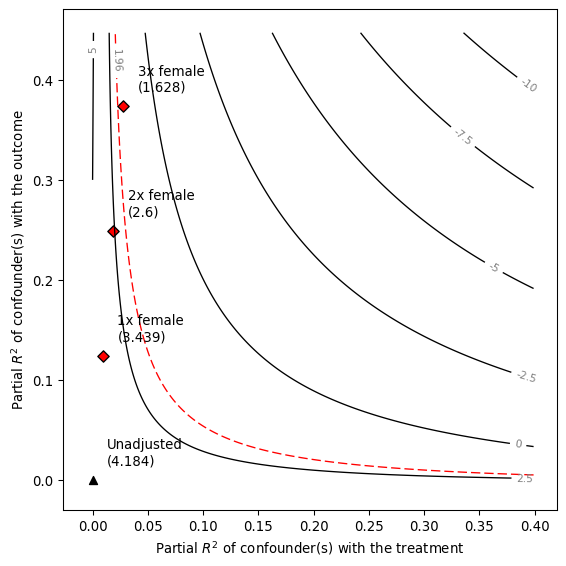

In [10]:
# contour plot for t-value
darfur_sense.plot(sensitivity_of = 't-value')

The plot reveals that, at the 5% significance level, the null hypothesis of zero effect would still be rejected given confounders once or twice as strong as `female`. However, by contrast to the point-estimate, accounting for sampling uncertainty now means that the null hypothesis of zero effect *would not* be rejected with the inclusion of a confounder three times as strong as `female`. 

### Sensitivity to extreme scenarios

Sometimes researchers may be better equipped to make plausibility judgments about the strength of determinants of the treatment assignment mechanism, and have less knowledge about the determinants of the outcome. In those cases, sensitivity plots using *extreme scenarios* are a useful option. These are produced with the option `plot_type = extreme`. Here one assumes confounding explains **all** or some large fraction of the residual variance of the outcome, then vary how strongly such confounding is hypothetically related to the treatment, to see how this affects the resulting point estimate.

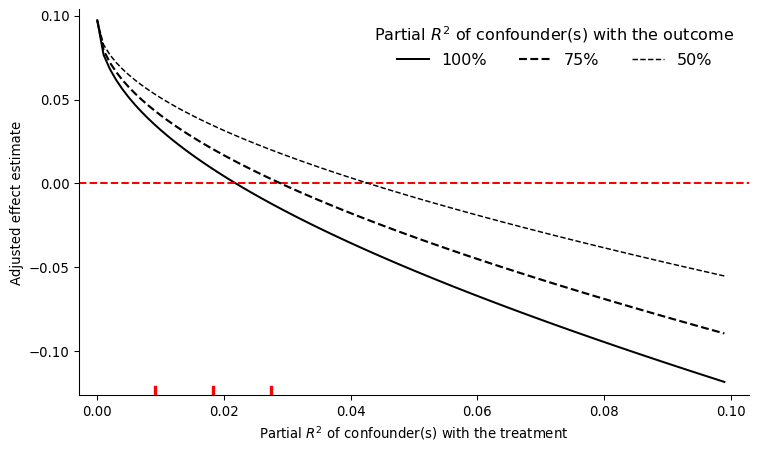

In [11]:
# extreme scenarios plot
darfur_sense.plot(plot_type = 'extreme')

This extreme scenarios plot sets the association of confounders with the outcome to  $R^2_{Y\sim Z| {\bf X}, D}$=100%,  $R^2_{Y\sim Z| {\bf X}, D}$=75%  and  $R^2_{Y\sim Z| {\bf X}, D}$=50% (producing three separate curves). The bounds on the strength of association of a confounder once, twice or three times as strongly associated with the treatment as `female` are shown as red ticks in the horizontal axis.  As the plot shows, even in the most extreme case of $R^2_{Y\sim Z| {\bf X}, D}$=100%, confounders would need to be more than twice as strongly associated with the treatment to fully explain away the point estimate. Moving to  the scenarios $R^2_{Y\sim Z| {\bf X}, D}$=75%  and  $R^2_{Y\sim Z| {\bf X}, D}$=50%, confounders would need to be more than three times as strongly associated with the treatment as was female in order to fully explain away the point estimate.

## Going further
The basic functionality demonstrated here will likely suffice for most users, most of the time. Sometimes, however, more flexibility will be needed in a given project. When this happens, researchers may resort directly to the functions defined in the other modules of the package. Those functions can be found in the Modules documentation, and we also provide some examples of how they can be used in the next notebook.

## References
Cinelli, C. Hazlett, C. (2020) “Making Sense of Sensitivity: Extending Omitted Variable Bias”. Journal of the Royal Statistical Society, Series B (Statistical Methodology).

Hazlett, C. (2019). Angry or Weary? How Violence Impacts Attitudes toward Peace among Darfurian Refugees. Journal of Conflict Resolution.